In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.backend import set_session
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

from models import VGG

print(tf.__version__)

c:\program files\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.11.0


In [2]:
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
# config.log_device_placement = True  # to log device placement (on which device the operation ran)
#                                     # (nothing gets printed in Jupyter, only if you run it standalone)
# sess = tf.Session(config=config)
# set_session(sess)  # set this TensorFlow session as the default session for Keras

In [3]:
data = np.load(r'data/dataset.npy')

In [4]:
data.shape

(3188, 256, 256, 3)

In [5]:
data = data / 255.0

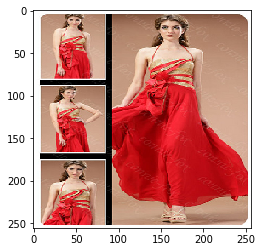

In [6]:
plt.imshow(data[0])
plt.show()

In [7]:
train_data, test_data = train_test_split(data)
test_data, val_data = train_test_split(test_data, test_size=0.2)

In [8]:
print('train_data.shape = {}'.format(train_data.shape))
print('test_data.shape = {}'.format(test_data.shape))
print('val_data.shape = {}'.format(val_data.shape))

train_data.shape = (2391, 256, 256, 3)
test_data.shape = (637, 256, 256, 3)
val_data.shape = (160, 256, 256, 3)


In [9]:
train_data[0:32].shape

(32, 256, 256, 3)

In [10]:
epochs = 10
steps_per_epoch = 74
def generator():
    for ep in range(epochs):
        x = 0
        np.random.shuffle(train_data)
        for i in range(steps_per_epoch):
            yield train_data[x:x+32], train_data[x:x+32]
            x += 32
dataset = tf.data.Dataset.from_generator(generator, (tf.float32, tf.float32))

In [17]:
batch_norm = False
input_img = keras.layers.Input(shape=(256,256,3))

# ENCODER =======>|

# CONV2
x = keras.layers.Conv2D(32, kernel_size=(3,3), activation=keras.activations.relu, padding='same')(input_img)
if(batch_norm):
    x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling2D(pool_size=(2,2))(x)

x = keras.layers.Conv2D(64, kernel_size=(3,3), activation=keras.activations.relu, padding='same')(x)
if(batch_norm):
    x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling2D(pool_size=(2,2))(x)

# CONV3
x = keras.layers.Conv2D(128, kernel_size=(3,3), activation=keras.activations.relu, padding='same')(x)
if(batch_norm):
    x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling2D(pool_size=(2,2))(x)

# <======== ENCODER

# DECODER ============>
# CONV4
x = keras.layers.Conv2D(128, kernel_size=(3,3), activation=keras.activations.relu, padding='same')(x)
x = keras.layers.UpSampling2D((2,2))(x)

# CONV4
x = keras.layers.Conv2D(64, kernel_size=(3,3), activation=keras.activations.relu, padding='same')(x)
x = keras.layers.UpSampling2D((2,2))(x)

x = keras.layers.Conv2D(32, kernel_size=(3,3), activation=keras.activations.relu, padding='same')(x)
x = keras.layers.UpSampling2D((2,2))(x)

x = keras.layers.Conv2D(3, kernel_size=(3,3), activation=keras.activations.sigmoid, padding='same')(x)
# <============ DECODER

model = keras.models.Model(input_img, x)

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 128)       0         
__________

In [19]:
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.binary_crossentropy)

In [20]:
model.fit(dataset, steps_per_epoch=steps_per_epoch, epochs=epochs, callbacks=[TensorBoard(log_dir=r'E:\workspace\python\cs231n\tmp\autoencoder')])

Epoch 1/10
74/74 [==============================] - 37s 497ms/step - loss: 17.6895
Epoch 2/10
74/74 [==============================] - 34s 456ms/step - loss: 15.5279
Epoch 3/10
74/74 [==============================] - 34s 456ms/step - loss: 15.3292
Epoch 4/10
74/74 [==============================] - 33s 449ms/step - loss: 15.2437
Epoch 5/10
74/74 [==============================] - 34s 455ms/step - loss: 15.1652
Epoch 6/10
74/74 [==============================] - 34s 458ms/step - loss: 15.1170
Epoch 7/10
74/74 [==============================] - 34s 464ms/step - loss: 15.0753
Epoch 8/10
74/74 [==============================] - 34s 463ms/step - loss: 15.0606
Epoch 9/10
74/74 [==============================] - 34s 454ms/step - loss: 15.0126
Epoch 10/10
74/74 [==============================] - 33s 447ms/step - loss: 15.0200


In [21]:
decoded_imgs = model.predict(test_data)

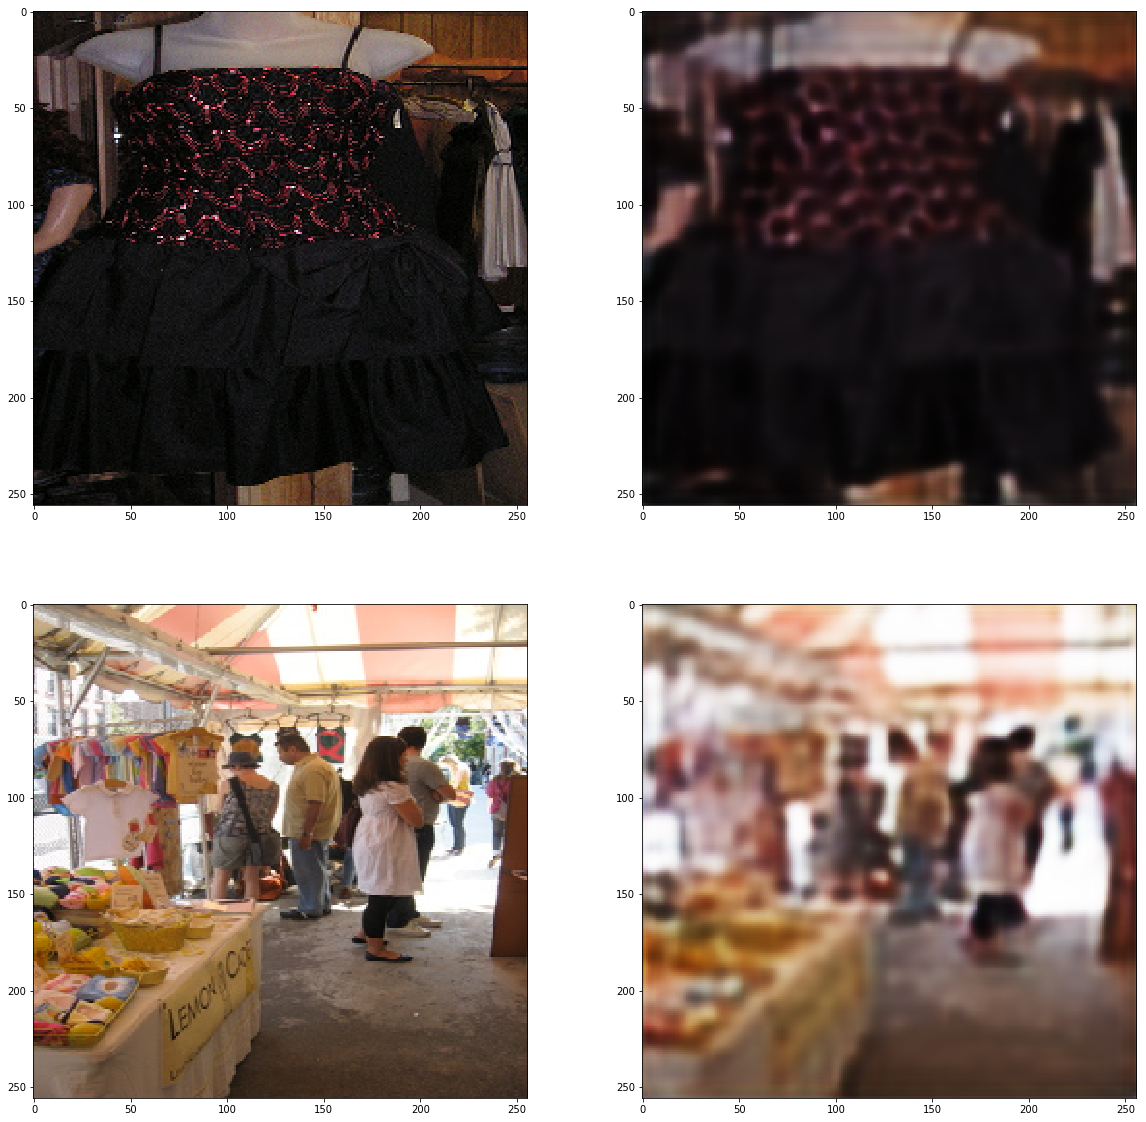

In [22]:
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.imshow(test_data[2])
plt.subplot(2,2,2)
plt.imshow(decoded_imgs[2])

plt.subplot(2,2,3)
plt.imshow(test_data[20])
plt.subplot(2,2,4)
plt.imshow(decoded_imgs[20])
plt.show()

In [26]:
def input_fn():
  return tf.train.limit_epochs(
      tf.convert_to_tensor(test_data, dtype=tf.float32), num_epochs=1)

num_clusters = 5
kmeans = tf.contrib.factorization.KMeansClustering(
    num_clusters=num_clusters, use_mini_batch=False)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_protocol': None, '_keep_checkpoint_max': 5, '_log_step_count_steps': 100, '_eval_distribute': None, '_global_id_in_cluster': 0, '_device_fn': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_keep_checkpoint_every_n_hours': 10000, '_is_chief': True, '_tf_random_seed': None, '_service': None, '_train_distribute': None, '_experimental_distribute': None, '_master': '', '_task_id': 0, '_model_dir': 'C:\\Users\\slin\\AppData\\Local\\Temp\\tmpwu47m_j5', '_save_checkpoints_secs': 600, '_evaluation_master': '', '_task_type': 'worker', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000015771A18400>}


In [29]:
# train
num_iterations = 10
previous_centers = None
for _ in range(num_iterations):
  kmeans.train(input_fn)
  cluster_centers = kmeans.cluster_centers()
  if previous_centers is not None:
    print('delta:', cluster_centers - previous_centers)
  previous_centers = cluster_centers
  print('score:', kmeans.score(input_fn))
print('cluster centers:', cluster_centers)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\slin\AppData\Local\Temp\tmpwu47m_j5\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\slin\AppData\Local\Temp\tmpwu47m_j5\model.ckpt.
INFO:tensorflow:Loss for final step: None.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-10-09-02:18:28
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\slin\AppData\Local\Temp\tmpwu47m_j5\model.ckpt-1
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


InvalidArgumentError: Input points should be a matrix.
	 [[{{node NearestNeighbors}} = NearestNeighbors[_class=["loc:@Squeeze"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](Const, clusters/read/_31, NearestNeighbors/k, ^limit_epochs/CountUpTo)]]

Caused by op 'NearestNeighbors', defined at:
  File "c:\program files\python35\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\program files\python35\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\program files\python35\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\program files\python35\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "c:\program files\python35\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "c:\program files\python35\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "c:\program files\python35\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "c:\program files\python35\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\program files\python35\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "c:\program files\python35\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "c:\program files\python35\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "c:\program files\python35\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\program files\python35\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "c:\program files\python35\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "c:\program files\python35\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "c:\program files\python35\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\program files\python35\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\program files\python35\lib\site-packages\IPython\core\interactiveshell.py", line 2683, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\program files\python35\lib\site-packages\IPython\core\interactiveshell.py", line 2787, in run_ast_nodes
    if self.run_code(code, result):
  File "c:\program files\python35\lib\site-packages\IPython\core\interactiveshell.py", line 2847, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-29-ff4ed240a739>", line 10, in <module>
    print('score:', kmeans.score(input_fn))
  File "c:\program files\python35\lib\site-packages\tensorflow\contrib\factorization\python\ops\kmeans.py", line 456, in score
    return self.evaluate(input_fn=input_fn, steps=1)[KMeansClustering.SCORE]
  File "c:\program files\python35\lib\site-packages\tensorflow\python\estimator\estimator.py", line 476, in evaluate
    return _evaluate()
  File "c:\program files\python35\lib\site-packages\tensorflow\python\estimator\estimator.py", line 462, in _evaluate
    self._evaluate_build_graph(input_fn, hooks, checkpoint_path))
  File "c:\program files\python35\lib\site-packages\tensorflow\python\estimator\estimator.py", line 1422, in _evaluate_build_graph
    self._call_model_fn_eval(input_fn, self.config))
  File "c:\program files\python35\lib\site-packages\tensorflow\python\estimator\estimator.py", line 1458, in _call_model_fn_eval
    features, labels, model_fn_lib.ModeKeys.EVAL, config)
  File "c:\program files\python35\lib\site-packages\tensorflow\python\estimator\estimator.py", line 1169, in _call_model_fn
    model_fn_results = self._model_fn(features=features, **kwargs)
  File "c:\program files\python35\lib\site-packages\tensorflow\contrib\factorization\python\ops\kmeans.py", line 205, in model_fn
    kmeans_plus_plus_num_retries=self._kmeans_plus_plus_num_retries
  File "c:\program files\python35\lib\site-packages\tensorflow\contrib\factorization\python\ops\clustering_ops.py", line 382, in training_graph
    all_scores, scores, cluster_idx = self._infer_graph(inputs, cluster_centers)
  File "c:\program files\python35\lib\site-packages\tensorflow\contrib\factorization\python\ops\clustering_ops.py", line 262, in _infer_graph
    inp, clusters, 1)
  File "c:\program files\python35\lib\site-packages\tensorflow\contrib\factorization\python\ops\gen_clustering_ops.py", line 217, in nearest_neighbors
    "NearestNeighbors", points=points, centers=centers, k=k, name=name)
  File "c:\program files\python35\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "c:\program files\python35\lib\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "c:\program files\python35\lib\site-packages\tensorflow\python\framework\ops.py", line 3272, in create_op
    op_def=op_def)
  File "c:\program files\python35\lib\site-packages\tensorflow\python\framework\ops.py", line 1768, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Input points should be a matrix.
	 [[{{node NearestNeighbors}} = NearestNeighbors[_class=["loc:@Squeeze"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](Const, clusters/read/_31, NearestNeighbors/k, ^limit_epochs/CountUpTo)]]
